In [4]:
import lmdb
import xml.etree.ElementTree as ET
import networkx as nx
from tqdm import tqdm
import numpy as np
import re
import shutil
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import os
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

os.chdir('/Users/bebr1814/projects/wikipedia')


## Load graph

In [5]:
class WikipediaGame:
	def __init__(self, wiki_xml_path=None, graph_pkl=None):

		self.exclude_prefixes = ['Module:', 'Template:', 'Wikipedia:', 'MediaWiki:', 'Category:', 'File:', 'Help:', 'Portal:', 'Draft:', 'Book:', 'User:', 'Special:', 'TimedText:', 'Talk:', 'Wikipedia talk:', 'MediaWiki talk:', 'Category talk:', 'File talk:', 'Template talk:', 'Module talk:']

		# DB to store text
		self.lmdb_path = "wikipedia_db"
		if os.path.exists(self.lmdb_path) and graph_pkl is None:
			shutil.rmtree(self.lmdb_path, ignore_errors=True) # delete LMDB database if it exists
		self.lmdb_env = lmdb.open(self.lmdb_path, map_size=20**9)  # 2GB max size

		# DB to store vectors
		# This should be generated beforehand
		self.vec_lmdb_path = "vector_db"
		if os.path.exists(self.vec_lmdb_path):
			self.vec_env = lmdb.open(self.vec_lmdb_path, readonly=True, lock=False)
		else:
			self.vec_env = None


		if graph_pkl is not None:
			self.G = pickle.load(open(graph_pkl, "rb"))
			self.article_titles = set(self.G.nodes())
		elif wiki_xml_path is not None:
			self.wiki_xml = wiki_xml_path
			self.build_graph()
		else:
			raise ValueError("Either wiki_xml_path or graph must be provided")

		self.pagerank = nx.pagerank(self.G, alpha=0.85)
		self.betweenness = None
		# nx.betweenness_centrality(self.G, normalized=True, k=1000)

	def store_article(self,title, content):
		with self.lmdb_env.begin(write=True) as txn:
			txn.put(title.encode(), content.encode())  # Store title → full text

	def get_article(self,title):
		with self.lmdb_env.begin() as txn:
			data = txn.get(title.encode())
			return data.decode() if data else None  # Retrieve full text by title
	
	def get_vector(self, title):
		if self.vec_env is None:
			raise RuntimeError("Vector LMDB is not initialized. Make sure vector_db exists.")

		with self.vec_env.begin() as txn:
			data = txn.get(title.encode())
			if data is None:
				return None
			return np.frombuffer(data, dtype=np.float32)

	def build_graph(self):
		"""Build the directed graph from Wikipedia XML."""
		print("Parsing XML...")
		tree = ET.parse(self.wiki_xml)
		root = tree.getroot()
		
		# Initialize a directed graph
		self.G = nx.DiGraph()
		self.article_titles = set()
		
		print("Building graph and extracting text content...")

		# get all article titles
		for page in tqdm(root[1:]):
			title = page.find('{http://www.mediawiki.org/xml/export-0.11/}title').text
			if any(title.startswith(prefix) for prefix in self.exclude_prefixes) or title in ['Global']:
				continue
			self.article_titles.add(title)
		
		
		# Iterate over the XML tree
		for page in tqdm(root[1:]):
			# Get the title of the page
			title = page.find('{http://www.mediawiki.org/xml/export-0.11/}title').text
			if any(title.startswith(prefix) for prefix in self.exclude_prefixes):
				continue

			# Get the text of the page
			text_element = page.find('{http://www.mediawiki.org/xml/export-0.11/}revision').find('{http://www.mediawiki.org/xml/export-0.11/}text')
			
			if text_element is not None:

				text = text_element.text
				if text is None or text == '':
					self.article_titles.remove(title)
					# Remove any links to this article from the graph
					if self.G.has_node(title):
						self.G.remove_node(title)
					continue

				# Store the text content in the LMDB database
				self.store_article(title, self.clean_wikipedia_text(text))

				# Find all links in the text using regex
				try:
					links = re.findall(r'\[\[([^|\]]+)(?:\|[^\]]*)?\]\]', text)
					# Exclude links that aren't valid articles
					links = list(self.article_titles.intersection(links))
					
					# Add the links to the graph
					if len(links) > 0:
						for link in links:
							self.G.add_edge(title, link)
					else:
						# Add the node even if it has no outgoing links
						self.G.add_node(title)
				except Exception as e:
					print(f"{title} processing error: {e}")
			else:
				print(f"{title} has no text content")
		
		# print("Vectorizing all articles...")
		# self.vectorize_all()
		
		print(f"Graph built with {len(self.G.nodes())} nodes and {len(self.G.edges())} edges")
	
	def clean_wikipedia_text(self,text):
		
		# Remove {{templates}}
		text = re.sub(r"\{\{.*?\}\}", "", text)

		# Remove [[File:...]] and similar media references
		text = re.sub(r"\[\[File:.*?\]\]", "", text)

		# Remove section headers (== Title ==)
		text = re.sub(r"==+.*?==+", "", text)

		# Remove [[Category:...]] tags (if present in raw text)
		text = re.sub(r"\[\[Category:.*?\]\]", "", text)

		# Replace [[linked text|display text]] with just "display text"
		text = re.sub(r"\[\[([^|\]]+\|)?([^\]]+)\]\]", r"\2", text)

		# Remove all remaining [[brackets]] (if any)
		text = re.sub(r"\[\[|\]\]", "", text)

		# Remove extra whitespace and newlines
		text = re.sub(r"\s+", " ", text).strip()

		# Remove \'
		text = text.replace("\'", "")
		
		return text


In [6]:
# wiki_game = WikipediaGame(wiki_xml_path='/Users/bebr1814/projects/wikipedia/data/simplewiki-20250301-pages-articles-multistream.xml')

# with open('/Users/bebr1814/projects/wikipedia/pickles/simplewiki_full_graph.4.15.25.pkl', 'wb') as f:
# 	pickle.dump(wiki_game.G, f)

# with open('/Users/bebr1814/projects/wikipedia/pickles/simplewiki_full_graph.betweenness.pkl', 'wb') as f:
# 	pickle.dump(wiki_game.betweenness, f)

In [7]:
wiki_game = WikipediaGame(graph_pkl='/Users/bebr1814/projects/wikipedia/pickles/simplewiki_full_graph.4.15.25.pkl')
wiki_game.betweenness = pickle.load(open('/Users/bebr1814/projects/wikipedia/pickles/simplewiki_full_graph.betweenness.pkl', "rb"))

pairs = pd.read_csv('test_pairs.tsv', sep='\t')

In [8]:
wiki_game.get_article('Security-Enhanced Linux')

'thumb|right|The SELinux administrator in Fedora (operating system)|Fedora 8 Security-Enhanced Linux (SELinux) is a Linux feature that gives a variety of security rules, including mandatory access controls. It does so by using Linux Security Modules (LSM) in the Linux kernel. It is not a Linux distribution, but rather a group of changes that can be used on Unix-like operating systems, such as Linux and BSD.'

In [9]:
wiki_game.get_vector('Security-Enhanced Linux')

array([ 3.49591449e-02, -1.25363609e-02, -3.64816152e-02,  2.78028892e-05,
        1.36486918e-01, -1.76118240e-02,  2.41619255e-02,  9.86313745e-02,
       -5.06293215e-02, -7.80712590e-02,  5.96723147e-02,  4.46877219e-02,
       -3.04713864e-02, -5.81546575e-02,  1.98160820e-02, -3.48866954e-02,
        2.83649862e-02,  1.21961646e-02, -5.96932024e-02, -5.53695932e-02,
       -5.65569848e-03, -3.29952687e-02, -2.79037207e-02,  1.22546228e-02,
       -3.64687219e-02, -4.65247557e-02, -7.60664865e-02, -1.89227343e-03,
        4.52343002e-02, -6.43991530e-02, -3.10904514e-02,  1.65180210e-02,
        4.04766388e-02,  2.99598416e-03, -7.12891668e-02,  2.81087626e-02,
        6.86487332e-02, -6.00882582e-02, -6.71593100e-02, -8.08424607e-04,
       -9.04838741e-02, -3.30148414e-02, -6.97469041e-02, -1.38829984e-02,
       -5.22204265e-02, -1.19845215e-02,  3.16130742e-02, -2.52068564e-02,
       -1.32169481e-02,  2.07248274e-02,  3.64207849e-02,  6.13596886e-02,
        4.16596308e-02,  

In [10]:
wiki_game.betweenness['Security-Enhanced Linux']

1.4714490703565305e-06

In [11]:
# blacklist = []
# for title in wiki_game.article_titles:
# 	if wiki_game.get_article(title) is None:
# 		blacklist.append(title)

## Helper Functions

In [12]:

def generate_path_stats(source, target, wiki_game):
	"""
	Generate a dataframe containing statistics for the top 20 successors
	at each step along the shortest path from source to target.
	"""
	try:
		# Get the shortest path from source to target
		shortest_path = nx.shortest_path(wiki_game.G, source, target)
	except nx.NetworkXNoPath:
		print(f"No path exists between {source} and {target}")
		return pd.DataFrame()  # Return an empty DataFrame if no path exists

	stats = pd.DataFrame(columns=['source', 'target', 'current_node', 'selection', 'path_length', 'sem_sim', 'pagerank', 'out_degree', 'betweenness_centrality', 'step'])

	# Loop through each node in the shortest path (except the last one)
	for step, current_node in enumerate(shortest_path[:-2], start=1):
		paths = []
		# Get the successors of the current node
		for suc in wiki_game.G.successors(current_node):
			try:
				path_length = len(nx.shortest_path(wiki_game.G, suc, target))
				paths.append((suc, path_length))
			except:
				# paths.append((suc, float('inf')))
				pass

		# Add the successors to the DataFrame
		for suc, path_length in paths:
			stats.loc[len(stats)] = {
				'source': source,
				'target': target,
				'current_node': current_node,
				'selection': suc,
				'path_length': path_length,
				'sem_sim': semantic_similarity(current_node, suc, wiki_game),
				'pagerank': wiki_game.pagerank[suc],
				'out_degree': wiki_game.G.out_degree(suc),
				'betweenness_centrality': wiki_game.betweenness[suc],
				'step': step
			}

	return stats

def visualize_path_stats(stats, metrics=['out_degree', 'sem_sim']):
	"""
	Visualize the distribution of specified metrics at each step of the path using boxplots.
	"""

	stats.sort_values('path_length', ascending=False, inplace=True)

	# fig, axes = plt.subplots(2,1,figsize=(7, 9), dpi=300)
	# for i, metric in enumerate(metrics):
	# 	# Create a boxplot for the metric with step as the x-axis
	# 	# sns.boxplot(data=stats, x='step', y=metric, ax=axes[i], color='white')
	# 	sns.stripplot(data=stats, x='step', y=metric, ax=axes[i], hue='path_length', palette='RdBu', alpha=0.8, linewidth=0.5, edgecolor='black')
	# 	axes[i].set_title(f'Distribution of {metric} at Each Step')
	# 	axes[i].set_xlabel('Step')
	# 	axes[i].set_ylabel(metric)
	# 	sns.despine()

	# Instead, make a scatterplot for each step
	x = 'sem_sim'
	# y = 'out_degree'
	y = 'betweenness_centrality'

	nrows,ncols = stats['step'].nunique() / 3 + 1, 3
	fig, axes = plt.subplots(int(nrows), int(ncols), figsize=(15, 5*nrows), dpi=300)
	axes = axes.flatten()
	for step in stats['step'].unique():
		step_stats = stats[stats['step'] == step]
		sns.scatterplot(data=step_stats, x=x, y=y, hue='path_length', palette='RdBu', ax=axes[int(step)-1], alpha=0.8, linewidth=0.5, edgecolor='black')
		# label the best nodes (min path length)
		best_nodes = step_stats[step_stats['path_length'] == step_stats['path_length'].min()]
		for i, row in best_nodes.iterrows():
			axes[int(step)-1].text(row[x], row[y], row['selection'], fontsize=8, ha='right', va='bottom')
		axes[int(step)-1].set_title(f'Step {int(step)}: {len(step_stats)} nodes')
		axes[int(step)-1].set_xlabel(x)
		axes[int(step)-1].set_ylabel(y)
		sns.despine()
	# Adjust layout
	plt.tight_layout()
	

## Heuristic Method

In [13]:

def compute_composite_score(semantic_score, betweenness_score, connectivity_score):
    # Normalize input values
    norm_semantic = (semantic_score + 1) / 2  # Convert from [-1,1] to [0,1]
    norm_betweenness = np.log(betweenness_score + 1)  # Logarithmic scale for betweenness
    norm_connectivity = np.log(connectivity_score + 1)  # Logarithmic scale for connectivity
    
    # Fixed weights
    alpha = 0.4  # Semantic similarity weight
    beta = 0.4   # Betweenness centrality weight
    gamma = 0.2  # Connectivity weight
    
    # Calculate composite score
    composite_score = (alpha * norm_semantic) + (beta * norm_betweenness) + (gamma * norm_connectivity)
    return composite_score

def semantic_similarity(node1, node2, wiki_game):
	"""
	Calculate semantic similarity between two nodes using their vector embeddings.
	
	Parameters:
	- node1: The first node (article title).
	- node2: The second node (article title).
	- wiki_game: Instance of WikipediaGame class.

	Returns:
	- A float representing the cosine similarity between the two nodes' embeddings.
	"""
	vec1 = wiki_game.get_vector(node1)
	vec2 = wiki_game.get_vector(node2)
	
	if vec1 is None or vec2 is None:
		return 0.0  # Return 0 if either vector is missing
	
	# Compute cosine similarity
	dot_product = np.dot(vec1, vec2)
	norm1 = np.linalg.norm(vec1)
	norm2 = np.linalg.norm(vec2)
	
	if norm1 == 0 or norm2 == 0:
		return 0.0  # Avoid division by zero
	
	similarity = dot_product / (norm1 * norm2)
	return similarity

def heuristic_choice(source, target, wiki_game, neighbors):
    # List to store neighbors and their scores
    scored_neighbors = {}
    
    # Score each neighbors
    for neighbor in neighbors:
        semantic_score = semantic_similarity(neighbor, target, wiki_game)
        betweenness_score = wiki_game.betweenness[neighbor]
        connectivity_score = wiki_game.G.out_degree(neighbor)
        
        scored_neighbors[neighbor] = compute_composite_score(semantic_score, betweenness_score, connectivity_score)

    # Sort the scored neighbors by score in descending order
    scored_neighbors = sorted(scored_neighbors.items(), key=lambda x: x[1], reverse=True)
    
    return scored_neighbors[0][0]


## ML

In [14]:
def make_training_set(wiki_game, num_pairs=1e5):
	n = 0
	i = 0


	train_df = pd.DataFrame(columns=['path_length', 'sem_sim', 'pagerank', 'out_degree', 'betweenness_centrality', 'shortest_path'])

	while n < num_pairs:
		source, target = random.sample(list(wiki_game.article_titles), 2)
		if source != target and nx.has_path(wiki_game.G, source, target):
			i += 1

			stats = generate_path_stats(source, target, wiki_game)
			if not stats.empty:
				stats.dropna(inplace=True)
				for step in stats['step'].unique():
					step_stats = stats[stats['step'] == step][['path_length', 'sem_sim', 'pagerank', 'out_degree', 'betweenness_centrality']]
					step_stats['shortest_path'] = step_stats['path_length'] == step_stats['path_length'].min()
					if len(step_stats) >= 10:
						# keep all the rows with the shortest path length, or the top 5 if there are fewer than 5 shortest
						shortest_path_length = step_stats['path_length'].min()
						shortest_path_stats = step_stats[step_stats['path_length'] == shortest_path_length]
						# if len(shortest_path_stats) < 3:
						# 	shortest_path_stats = step_stats.nlargest(3, 'path_length')
						# sample the same number of rows from the rest to try to keep the balance
						rest_stats = step_stats[~step_stats.index.isin(shortest_path_stats.index)]
						if len(rest_stats) > 0:
							sample_size = min(len(shortest_path_stats), len(rest_stats))
							rest_stats = rest_stats.sample(n=sample_size, random_state=42)
							step_stats = pd.concat([shortest_path_stats, rest_stats], ignore_index=True)
						else:
							step_stats = shortest_path_stats
					train_df = pd.concat([train_df, step_stats], ignore_index=True)
					n += len(step_stats)
	return train_df

In [15]:
def train_model(train_df,test_size=0.2):
	X = train_df[['sem_sim', 'pagerank', 'out_degree', 'betweenness_centrality']]
	# y = train_df['path_length']
	y = train_df['shortest_path'].astype(int)

	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

	model = RandomForestClassifier(n_estimators=100, random_state=42)
	# model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

	model.fit(X_train, y_train)

	return model, X_train, X_test, y_train, y_test

def evaluate_model_regression(model, X_test, y_test):
	from sklearn.metrics import mean_squared_error, r2_score
	y_pred = model.predict(X_test)
	mse = mean_squared_error(y_test, y_pred)
	r2 = r2_score(y_test, y_pred)
	return mse, r2

def evaluate_model_classification(model, X_test, y_test):
	from sklearn.metrics import classification_report, accuracy_score
	y_pred = model.predict(X_test)
	accuracy = accuracy_score(y_test, y_pred)
	print(accuracy)
	report = classification_report(y_test, y_pred)
	print(report)
	return accuracy, report

def plot_feature_importances(model, feature_names):
	importances = model.feature_importances_
	indices = np.argsort(importances)[::-1]

	plt.figure(figsize=(4,3),dpi=200)
	plt.title("Feature importances")
	plt.bar(range(len(feature_names)), importances[indices], align="center")
	plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
	plt.xlim([-1, len(feature_names)])
	sns.despine()
	plt.show()

def generate_neighbor_stats(source, target, wiki_game):
	# Just make a small df with the stats from the successors of source
	stats = pd.DataFrame(columns=['selection', 'sem_sim', 'pagerank', 'out_degree', 'betweenness_centrality'])
	neighbors = wiki_game.G.successors(source)
	for suc in neighbors:
		stats.loc[len(stats)] = {
			'selection': suc,
			'sem_sim': semantic_similarity(source, suc, wiki_game),
			'pagerank': wiki_game.pagerank[suc],
			'out_degree': wiki_game.G.out_degree(suc),
			'betweenness_centrality': wiki_game.betweenness[suc]
		}
	return stats



In [16]:
def ml_choice(source, target, wiki_game, neighbors, model):

	# get stats
	stats = generate_neighbor_stats(source, target, wiki_game)
	X = stats[['sem_sim', 'pagerank', 'out_degree', 'betweenness_centrality']]
	neighbors = [n for n in stats['selection'].values if n in neighbors]

	# predict the path length
	y_pred = model.predict_proba(X)[:, 1]  # Probability of being in the shortest path
	neighbors = [(neighbors[i], y_pred[i]) for i in range(len(neighbors))]

	# sort by predicted path length
	neighbors.sort(key=lambda x: x[1], reverse=True)

	return neighbors[0][0]

## Heuristic with Milestones

In [17]:

def heuristic_milestone_navigation(source, target, wiki_game):
	min_out_degree = 4

	real_source = source
	real_target = target

	best_num_phases = -1
	best_path = []

	for num_phases in range(0,5):

		# print('\n\nRunning with', num_phases, 'phases')

		visited = set([real_source])

		path_failed = False

		# Select top landmarks based on betweenness centrality
		landmarks = sorted(wiki_game.betweenness.items(), key=lambda x: x[1], reverse=True)[:500]

		# Calculate milestones for evenly spaced phases
		# For example, with 2 phases we would do max similarity to the source and the one with max similarity to both source and target
		# with 3 phases we would do max similarity to the source, max similarity to the target, and max similarity of those two
		# etc.
		milestones = []
		landmarks_not_self = [x for x in landmarks if x[0] != real_source and x[0] != real_target]
		for i in range(num_phases):
			# if i == 0:
			# 	milestone = max(landmarks_not_self, key=lambda x: semantic_similarity(x[0], real_source, wiki_game))
			# elif i == num_phases - 1:
			# 	milestone = max(landmarks_not_self, key=lambda x: semantic_similarity(x[0], real_target, wiki_game))
			# else:
			# 	milestone = max(landmarks_not_self, key=lambda x: semantic_similarity(x[0], milestones[i-1][0], wiki_game) + semantic_similarity(x[0], real_target, wiki_game))
			# milestones.append(milestone[0])

			if i == num_phases - 1:
				milestone = max(landmarks_not_self, key=lambda x: semantic_similarity(x[0], real_source, wiki_game))
			elif i == 0:
				milestone = max(landmarks_not_self, key=lambda x: semantic_similarity(x[0], real_target, wiki_game))
			else:
				milestone = max(landmarks_not_self, key=lambda x: semantic_similarity(x[0], milestones[0][0], wiki_game))
			
			milestones.insert(0, milestone[0])
			landmarks_not_self.remove(milestone)

		# print("Milestones:", milestones)

		path = [real_source]

		for phase in range(1, num_phases + 2):

			if path_failed:
				break
			if phase > 1:
				source = milestones[phase - 2]
			else:
				source = real_source

			if phase <= num_phases:
				target = milestones[phase - 1]
			else:
				target = real_target

			if source == target:
				# milestones are the same, just skip
				continue

			current = source

			# print('\nPhase', phase, '-', source, '->', target)

			i = 0

			while True:
				if i > 100:
					# print('\nToo many iterations, stopping.')
					path_failed = True
					break

				visited.add(current)

				neighbors = list(wiki_game.G.successors(current))

				if target in neighbors:
					current = target
					visited.add(current)
					path.append(current)
					# print(f' -> {target}!', end='')
					break

				if real_target in neighbors or real_target == current:
					current = real_target
					path.append(current)
					# print(f' -> {real_target}!', end='')
					break

				if target == current or real_target == current:
					break

				neighbors = [n for n in neighbors if n not in visited]
				if len(neighbors) == 0:
					# backtrack
					if len(path) <= 1:
						path_failed = True
						break
					current = path[-2]
					path.append(current)
					i += 1
					continue

				# filter by out_degree
				out_degrees = [wiki_game.G.out_degree(n) for n in neighbors]
				if max(out_degrees) < min_out_degree:
					neighbors = [n for n in neighbors if wiki_game.G.out_degree(n) > 0]
				else:
					neighbors = [n for n in neighbors if wiki_game.G.out_degree(n) >= min_out_degree]

				if len(neighbors) == 0:
					# backtrack
					if len(path) <= 1:
						path_failed = True
						break
					current = path[-2]
					path.append(current)
					i += 1
					continue

				# select neighbor with highest semantic similarity
				sem_sim = -1
				for n in neighbors:
					sim = semantic_similarity(n, target, wiki_game)
					if sim > sem_sim:
						sem_sim = sim
						best_neighbor = n

				# if sem_sim == -1:
				# 	# print(f'\n[Sem Sim == 0]')
				# 	break

				# Navigate to the selection
				current = best_neighbor
				path.append(current)

				# print the selection
				# print(f' -> {current} ({sem_sim:.2f})', end='')
				i += 1

		# runs.loc[len(runs)] = {
		# 	'source': real_source,
		# 	'target': real_target,
		# 	'algo_path_length': len(path),
		# 	'failed': path_failed,
		# 	'num_phases': num_phases,
		# 	'real_path_length': len(nx.shortest_path(wiki_game.G, real_source, real_target))
		# }

		if (path_failed and len(best_path) == 0) or (not path_failed and (len(path) < len(best_path) or len(best_path) == 0)):
			best_path = path
			best_num_phases = num_phases
	
	return best_path


## Reinforcement Learning

In [18]:

class DQN(nn.Module):
	def __init__(self, input_dim, hidden_dim=256):  # Larger network
		super(DQN, self).__init__()
		self.fc = nn.Sequential(
			nn.Linear(input_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, hidden_dim),
			nn.ReLU(),
			nn.Linear(hidden_dim, hidden_dim // 2),  # Additional layer
			nn.ReLU(),
			nn.Linear(hidden_dim // 2, 1)
		)
		
		# Initialize weights properly
		for m in self.modules():
			if isinstance(m, nn.Linear):
				nn.init.xavier_uniform_(m.weight)
				nn.init.constant_(m.bias, 0)

	def forward(self, x):
		return self.fc(x)

class WikipediaAgent:
	def __init__(self, wiki_game, gamma=0.99, lr=1e-3, epsilon_start=1.0):
		self.wiki = wiki_game
		self.model = DQN(3)
		self.target_model = DQN(3)
		self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
		self.gamma = gamma
		self.epsilon = epsilon_start
		self.epsilon_end = 0.01
		self.epsilon_decay = 0.975
		self.memory = deque(maxlen=10000)
		self.batch_size = 64
		self.update_target()
		self.update_target_counter = 0
		self.update_target_freq = 100

	def update_target(self):
		self.target_model.load_state_dict(self.model.state_dict())

	def decay_epsilon(self):
		self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)

	def get_state_features(self, title, target):
		sem_sim = semantic_similarity(title, target, self.wiki)
		out_deg = self.wiki.G.out_degree(title)
		btw = self.wiki.betweenness[title]
		return [sem_sim, out_deg, btw]

	def choose_action(self, current_title, target_title, candidates=None, use_randomness=True):
		neighbors = candidates if candidates is not None else list(self.wiki.G.successors(current_title))
		if not neighbors:
			return None
		if use_randomness and random.random() < self.epsilon:
			return random.choice(neighbors)
		
		scores = []
		for n in neighbors:
			state = self.get_state_features(n, target_title)
			with torch.no_grad():
				q_val = self.model(torch.tensor(state, dtype=torch.float32))
			scores.append((q_val.item(), n))
		return max(scores, key=lambda x: x[0])[1]
	
	def compute_step_reward(self, prev_title, new_title, target_title):
		"""Compute immediate reward for a single step"""
		# Immediate success
		if new_title == target_title:
			return 20  # Big reward for finishing
		
		# Base step penalty to encourage shorter paths
		step_penalty = -0.5

		# Give a big penalty for moving away and a small penalty for staying the same distance
		prev_distance = nx.shortest_path_length(self.wiki.G, prev_title, target_title)
		new_distance = nx.shortest_path_length(self.wiki.G, new_title, target_title)

		if new_distance < prev_distance:
			return 2 + step_penalty
		elif new_distance == prev_distance:
			return -0.2 + step_penalty
		else:
			return -1 + step_penalty

	def compute_step_reward(self, prev_title, new_title, target_title):
		"""Compute immediate reward for a single step with better shaping"""
		# Immediate success
		if new_title == target_title:
			return 10  # Still good but not as extreme
		
		# Calculate distances
		prev_distance = nx.shortest_path_length(self.wiki.G, prev_title, target_title)
		new_distance = nx.shortest_path_length(self.wiki.G, new_title, target_title)
		
		# Reward based on distance change - more pronounced gradient
		if new_distance < prev_distance:
			return 5
		elif new_distance == prev_distance:
			return -0.5
		else:
			return -2


	def store_episode(self, trajectory):
		"""Store entire episode for Monte Carlo learning"""
		if trajectory:  # Only store if we have actual transitions
			self.memory.append(trajectory)

	def train_step_td(self):
		"""Train using TD learning instead of Monte Carlo returns"""
		if len(self.memory) < self.batch_size:
			return 0
		
		# Flatten trajectories to get individual transitions
		all_transitions = [t for trajectory in self.memory for t in trajectory]
		if len(all_transitions) < self.batch_size:
			return 0
			
		# Sample batch of transitions
		batch = random.sample(all_transitions, self.batch_size)
		states, action_feats, rewards, next_states, dones = zip(*batch)
		
		# Convert to tensors
		states_tensor = torch.tensor(np.stack(action_feats), dtype=torch.float32)
		rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
		next_states_tensor = torch.tensor(np.stack(next_states), dtype=torch.float32)
		dones_tensor = torch.tensor(dones, dtype=torch.float32)
		
		# Get current Q values
		current_q = self.model(states_tensor).squeeze()
		
		# Get next Q values from target network
		with torch.no_grad():
			next_q = self.target_model(next_states_tensor).squeeze()
		
		# Compute target Q values
		target_q = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q
		
		# Compute loss
		loss = nn.MSELoss()(current_q, target_q)
		
		# Optimize
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()
		
		# Update target network more frequently
		self.update_target_counter += 1
		if self.update_target_counter >= 10:  # More frequent updates (was 100)
			self.update_target()
			self.update_target_counter = 0
		
		return loss.item()

	def train_step_monte_carlo(self):
		"""Train using Monte Carlo returns instead of TD learning"""
		if len(self.memory) < 10:  # Need at least some episodes
			return 0
		
		# Sample a batch of episodes
		batch_episodes = random.sample(self.memory, min(self.batch_size, len(self.memory)))
		
		all_losses = []
		
		for episode in batch_episodes:
			if not episode:  # Skip empty episodes
				continue
				
			states, action_feats, rewards, next_states, dones = zip(*episode)
			
			# Calculate returns for each step in the episode
			returns = []
			G = 0
			for r in reversed(rewards):
				G = r + self.gamma * G
				returns.insert(0, G)
			
			# Convert to tensors
			states = torch.tensor(np.stack(action_feats), dtype=torch.float32)  # We use action features as states
			returns = torch.tensor(returns, dtype=torch.float32)
			
			# Get predicted values
			predicted_values = self.model(states).squeeze()
			
			# Calculate loss
			loss = nn.MSELoss()(predicted_values, returns)
			
			# Optimize
			self.optimizer.zero_grad()
			loss.backward()
			self.optimizer.step()
			
			all_losses.append(loss.item())
		
		# Update target network periodically
		self.update_target_counter += 1
		if self.update_target_counter >= self.update_target_freq:
			self.update_target()
			self.update_target_counter = 0
		
		return np.mean(all_losses) if all_losses else 0

	def play_episode(self, start_title, target_title, max_steps=20, max_attempts=3):
		"""Play an episode and store the trajectory for Monte Carlo learning"""
		for attempt in range(max_attempts):
			current = start_title
			trajectory = []
			visited = set([current])
			
			for step in range(max_steps):
				state = self.get_state_features(current, target_title)
				
				# Get available actions (exclude already visited)
				neighbors = list(self.wiki.G.successors(current))
				unvisited = [n for n in neighbors if n not in visited]
				
				# Handle target if available
				if target_title in unvisited:
					action = target_title
				else:
					if not unvisited:
						# Dead end - make this attempt invalid
						trajectory = []
						break
					action = self.choose_action(current, target_title, candidates=unvisited)
					if action is None or not nx.has_path(self.wiki.G, action, target_title):
						trajectory = []
						break
				
				visited.add(action)
				
				# Get next state features
				action_feat = self.get_state_features(action, target_title)
				reward = self.compute_step_reward(current, action, target_title)
				next_state = self.get_state_features(action, target_title)
				done = action == target_title
				
				# Store transition
				trajectory.append((state, action_feat, reward, next_state, done))
				
				# Update current state
				current = action
				
				if done:
					break
			
			# If we found a valid path, store it and exit retry loop
			if trajectory and (trajectory[-1][4] or len(trajectory) >= 3):
				# Only store if we reached the target or made at least 3 steps
				self.store_episode(trajectory)
				# self.train_step_monte_carlo()
				self.train_step_td()
				self.decay_epsilon()
				return trajectory
				
		# If all attempts failed, return empty trajectory
		return []

	def validate_path_exists(self, start, target):
		"""Check if there's a path between start and target"""
		try:
			# Just check if a path exists, not the actual path
			print(f"Checking path from {start} to {target}")
			path_exists = nx.has_path(self.wiki.G, start, target)
			return path_exists
		except (nx.NetworkXError, nx.NodeNotFound):
			return False
	
	def evaluate(self, start_title, target_title, max_steps=20, verbose=False):
		"""Run an episode for evaluation with backtracking for dead ends"""
		# First check if a path exists
		if not nx.has_path(self.wiki.G, start_title, target_title):
			if verbose:
				print(f"No path exists from {start_title} to {target_title}")
			return [], 0
				
		current = start_title
		path = [current]
		total_reward = 0
		visited = set([current])
		
		# Stack to keep track of our exploration path for backtracking
		exploration_stack = [(current, list(self.wiki.G.successors(current)))]
		
		step_count = 0
		while exploration_stack and step_count < max_steps:
			current, neighbors = exploration_stack[-1]
			
			if verbose:
				print(f"Step {step_count}: At {current}, stack depth: {len(exploration_stack)}")
			
			# Filter neighbors to those not visited
			unvisited = [n for n in neighbors if n not in visited]
			
			# Direct path to target if available
			if target_title in unvisited:
				path.append(target_title)
				reward = self.compute_step_reward(current, target_title, target_title)
				total_reward += reward
				if verbose:
					print(f"  Found target! Reward: {reward}")
				return path, total_reward
			
			if not unvisited:
				# Dead end - backtrack
				exploration_stack.pop()
				if exploration_stack:
					# Move back to previous node
					prev_node = exploration_stack[-1][0]
					if verbose:
						print(f"  Dead end at {current}, backtracking to {prev_node}")
					
					# Only add backtracking nodes to path if they're not already the last node
					if path[-1] != prev_node:
						path.append(prev_node)
						# Small penalty for backtracking
						total_reward -= 0.3
				continue
			
			# Choose best action
			scores = []
			for n in unvisited:
				state = self.get_state_features(n, target_title)
				with torch.no_grad():
					q_val = self.model(torch.tensor(state, dtype=torch.float32))
				scores.append((q_val.item(), n))
			
			scores = sorted(scores, key=lambda x: x[0], reverse=True)
			action = scores[0][1]
			i = 1
			while not nx.has_path(self.wiki.G, action, target_title):
				# give a penalty for choosing a dead end
				total_reward -= 4
				# choose the next best action
				action = scores[i][1]
				i += 1
				if i >= len(scores):
					# If we run out of options, we're in a dead end
					return path, total_reward
				

			
			# Remove this action from current neighbors
			exploration_stack[-1] = (current, [n for n in neighbors if n != action])
			
			# Mark as visited and proceed
			visited.add(action)
			reward = self.compute_step_reward(current, action, target_title)
			total_reward += reward
			
			if verbose:
				print(f"  Selected {action} with reward {reward:.4f}")
			
			current = action
			path.append(current)
			
			# Add new node to exploration stack
			exploration_stack.append((current, list(self.wiki.G.successors(current))))
			
			if current == target_title:
				if verbose:
					print("  Reached target!")
				break
				
			step_count += 1
		
		if verbose and current != target_title:
			print(f"  Failed to reach target after {len(path)} steps")
					
		return path, total_reward

	def train(self, episodes, start_pool, target_pool, max_steps=20):
		"""Train the agent for a specified number of episodes"""
		training_history = []
		successful_episodes = 0
		
		for episode in range(episodes):
			# Sample start and target
			start = random.choice(start_pool)
			target = random.choice(target_pool)
			
			# Make sure start and target are different and a path exists
			attempts = 0
			while (start == target or not self.validate_path_exists(start, target)) and attempts < 10:
				target = random.choice(target_pool)
				attempts += 1
				
			if attempts >= 10:
				# If we can't find a valid pair after multiple attempts, skip this episode
				continue
			
			# Play episode
			trajectory = self.play_episode(start, target, max_steps)
			
			# Calculate stats
			path_length = len(trajectory)
			total_reward = sum(t[2] for t in trajectory) if trajectory else 0
			success = trajectory and trajectory[-1][4]  # Check if the last step reached the target
			
			if success:
				successful_episodes += 1
			
			training_history.append({
				'episode': episode,
				'path_length': path_length,
				'total_reward': total_reward,
				'success': success,
				'epsilon': self.epsilon
			})
			
			# Optional: Print progress
			if episode % 10 == 0:
				success_rate = successful_episodes / (episode + 1) * 100 if episode > 0 else 0
				print(f"Episode {episode}, Success: {success}, Path Length: {path_length}, "
					  f"Reward: {total_reward:.2f}, Success Rate: {success_rate:.1f}%")
		
		return training_history

In [19]:
def train_rl(epochs=1000, agent=None):
	if agent is None:
		# Initialize the agent
		agent = WikipediaAgent(wiki_game)
	
	# Train for n epochs
	for epoch in tqdm(range(epochs)):
		start, target = random.sample(list(wiki_game.article_titles), 2)
		if nx.has_path(wiki_game.G, start, target):
			agent.play_episode(start, target)
		if epoch % 50 == 0:
			agent.update_target()

	return agent

In [20]:
def rl_choice(source, target, wiki_game, neighbors, agent):
    choice = agent.choose_action(source, target, candidates=neighbors, use_randomness=False)
    return choice

In [21]:
# # torch.save(agent.model.state_dict(), "wiki_dqn.4.22.25.pth")

# agent = WikipediaAgent(wiki_game)
# agent.model.load_state_dict(torch.load("wiki_dqn.4.22.25.pth"))
# agent.model.eval()  # set to inference mode

# navigate_reinforcement_learning('Apple', 'Moon', wiki_game, agent=agent)


## Navigation

In [22]:

def navigate(source, target, wiki_game, method, max_length=100, agent=None, model=None):

	# methods
	methods = ['heuristic','ml','rl']
	if method not in methods:
		raise ValueError(f"Method must be one of {methods}")
	if method == 'ml':
		assert model is not None, "Model must be provided for ML method"
	if method == 'rl':
		assert agent is not None, "Agent must be provided for RL method"

	# Start navigating
	visited = set()
	current = source
	path = [current]
	visited.add(current)

	i = 0
	while i < max_length:

		neighbors = list(wiki_game.G.successors(current))

		neighbors = [n for n in neighbors if n not in visited]
		
		# check if target is in neighbors
		if target in neighbors:
			path.append(target)
			return path
		
		# backtrack if no unvisited neighbors
		if len(neighbors) == 0:
			if len(path) <= 1:
				return path
			# Backtrack
			current = path[-2]
			path.append(current)
			i += 1
			continue
		
		# make a choice based on the method
		if method == 'heuristic':
			choice = heuristic_choice(current, target, wiki_game, neighbors)
		elif method == 'ml':
			choice = ml_choice(current, target, wiki_game, neighbors, model)
		elif method == 'rl':
			choice = rl_choice(current, target, wiki_game, neighbors, agent)
		
		# check if choice is valid
		assert choice in neighbors, f"Choice {choice} is not a neighbor of {current}"

		# add choice to path
		path.append(choice)
		visited.add(choice)
		current = choice
		
		i += 1
	
	return path

In [1]:
# navigate('Apple', 'Moon', wiki_game, method='heuristic')

In [2]:
# navigate('Apple', 'Moon', wiki_game, method='ml', model=model)

In [3]:
# navigate('Apple', 'Moon', wiki_game, method='rl', agent=agent)

## Comparisons

In [28]:
# # Classifier
# train_df = make_training_set(wiki_game, num_pairs=10000)

# train_df['out_degree'] = train_df['out_degree'].astype(int)
# train_df['sem_sim'] = train_df['sem_sim'].astype(float)

# # Split the data and train the model
# model, X_train, X_test, y_train, y_test = train_model(train_df)

# # Report performance
# acc, report = evaluate_model_classification(model, X_test, y_test)
# plot_feature_importances(model, X_train.columns)

# # Save the random forest model
import joblib
# joblib.dump(model, 'random_forest_model.4.28.25.pkl')

model = joblib.load('random_forest_model.4.28.25.pkl')
# navigate('Apple', 'Moon', wiki_game, method='ml', model=model)

In [29]:
agent = WikipediaAgent(wiki_game)
agent.model.load_state_dict(torch.load("wiki_dqn.4.22.25.pth"))

# for i in range(5):
# 	agent = train_rl(epochs=100, agent=agent)
# 	torch.save(agent.model.state_dict(), "wiki_dqn.4.22.25.pth")


<All keys matched successfully>

In [38]:
import time

pairs = pd.read_csv('test_pairs.tsv', sep='\t')

# Test pairs
max_length = 50
for i in tqdm(range(len(pairs))):
	source = pairs.iloc[i]['Source']
	target = pairs.iloc[i]['Target']

	
	for method in ['Heuristic', 'ML', 'RL']:
		if f'{method} path' not in pairs.columns:
			pairs[f'{method} path'] = 0
			pairs[f'{method} path'] = pairs[f'{method} path'].astype(object)
		start_time = time.time()
		if method == 'Heuristic':
			path = navigate(source, target, wiki_game, method='heuristic', max_length=max_length)
		elif method == 'ML':
			path = navigate(source, target, wiki_game, method='ml', model=model, max_length=max_length)
		elif method == 'RL':
			path = navigate(source, target, wiki_game, method='rl', agent=agent, max_length=max_length)
		end_time = time.time()
		# Add stats to the dataframe
		pairs.loc[i, f'{method} path length'] = len(path)
		pairs.at[i, f'{method} path'] = path
		pairs.loc[i, f'{method} time'] = end_time - start_time

pairs

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [12:21<00:00, 30.90s/it]


,Source,Target,My path length,Heuristic path,Heuristic path length,Heuristic time,ML path,ML path length,ML time,RL path,RL path length,RL time
0,Aaron Clauset,Paul Erdős,3,"[Aaron Clauset, Physics, Albert Einstein, Unit...",36.0,1.253698,"[Aaron Clauset, Computer science, List of word...",15.0,3.027043,"[Aaron Clauset, Physics, List of Jupiter's moo...",37.0,26.434564
1,Linux,Fred Rogers,11,"[Linux, List of Linux distributions, Poland, U...",51.0,1.470259,"[Linux, Linux Mint, Advanced Packaging Tool, D...",51.0,10.388906,"[Linux, List of Linux distributions, Poland, U...",51.0,34.977975
2,Wasabi,Adobe Inc.,22,"[Wasabi, Japan, United States, Ronald Reagan, ...",51.0,1.727856,"[Wasabi, New Zealand, Unitary state, Niger, Tu...",51.0,6.835197,"[Wasabi, Japan, United States, Ronald Reagan, ...",51.0,34.508489
3,Red (Taylor Swift album),Ulysses (novel),7,"[Red (Taylor Swift album), Taylor Swift, Speak...",51.0,1.662778,"[Red (Taylor Swift album), Americans, United S...",51.0,8.166886,"[Red (Taylor Swift album), Taylor Swift, YouTu...",51.0,33.562705
4,Batman,FC Bayern Munich,5,"[Batman, DC Extended Universe, DC Comics, Unit...",7.0,0.064375,"[Batman, Batman v Superman: Dawn of Justice, D...",51.0,8.481047,"[Batman, DC Extended Universe, DC Comics, Unit...",40.0,29.080184
5,Entropy,Tuberculosis,9,"[Entropy, Thermodynamic entropy, Earth, United...",51.0,1.836018,"[Entropy, Information entropy, Thermodynamic e...",51.0,9.675905,"[Entropy, Thermodynamic entropy, Earth, United...",51.0,28.869218
6,Brooklyn,Tom and Jerry,13,"[Brooklyn, New York City, United States, Ronal...",51.0,1.602427,"[Brooklyn, New York City, Morgan Stanley, Unit...",51.0,8.174529,"[Brooklyn, New York City, United States, Ronal...",51.0,29.712728
7,Frédéric Chopin,Ganymede (moon),7,"[Frédéric Chopin, France, ISO 4217, United Sta...",15.0,0.453630,"[Frédéric Chopin, Poland, Christianity, 21st c...",51.0,8.588700,"[Frédéric Chopin, France, ISO 4217, Country co...",16.0,11.389576
8,Rockhole frog,Alps,5,"[Rockhole frog, Australia, United States, Rona...",11.0,0.270896,"[Rockhole frog, Australia, United States, Fran...",5.0,1.068968,"[Rockhole frog, Australia, United States, Rona...",11.0,5.244258
9,Peach (color),Tokyo,5,"[Peach (color), China, France, Belgium, German...",8.0,0.080619,"[Peach (color), English language, United State...",9.0,1.892816,"[Peach (color), English language, United State...",6.0,1.310228


In [39]:
pairs.to_csv('pairs_stats.csv', index=False)

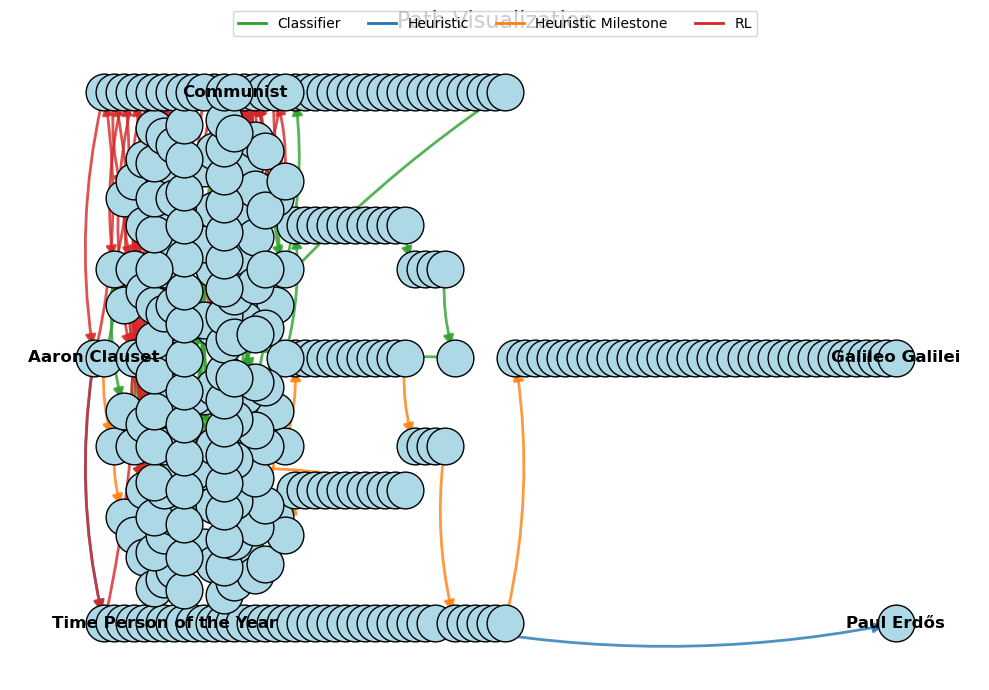

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# def visualize_paths_simple(paths, source, target, figsize=(10, 7)):
#     """
#     Build and visualize a directed graph from paths using NetworkX's built-in functionality.
    
#     Args:
#         paths: Dictionary of paths where keys are method names and values are lists of nodes
#         source: String representing the source node to position on the left
#         target: String representing the target node to position on the right
#         figsize: Tuple specifying figure dimensions
#     """
#     # Create a directed graph
#     G = nx.DiGraph()
    
#     # Track edges by path for coloring
#     edge_colors = []
#     edges_by_path = []
    
#     # Track first and last nodes of each path
#     path_endpoints = set()
    
#     # Add all paths as directed edges
#     for method, path in paths.items():
#         for i in range(len(path) - 1):
#             G.add_edge(path[i], path[i+1])
#             edges_by_path.append((path[i], path[i+1], method))
        
#         # Add the first and last nodes of each path to the endpoints set
#         if path:
#             path_endpoints.add(path[0])
#             path_endpoints.add(path[-1])
    
#     # Make sure source and target are in the graph even if they're not in any path
#     if source not in G:
#         G.add_node(source)
#     if target not in G:
#         G.add_node(target)
    
#     # Add source and target to endpoints
#     path_endpoints.add(source)
#     path_endpoints.add(target)
    
#     # Create the figure
#     plt.figure(figsize=figsize)
    
#     # Use a hierarchical layout (better for directed paths)
#     try:
#         # Try to use graphviz for better hierarchical layout
#         pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args='-Grankdir=LR')
#     except:
#         # Fall back to a custom layout if graphviz is not available
#         pos = {}
        
#         # First, compute longest path distance from source for each node
#         distances = {}
#         for node in G:
#             try:
#                 dist = nx.shortest_path_length(G, source=source, target=node)
#                 distances[node] = dist
#             except nx.NetworkXNoPath:
#                 # If no path from source, set a default distance
#                 distances[node] = 0
        
#         # Use distance for x-coordinate and spread nodes vertically
#         max_dist = max(distances.values()) if distances else 0
        
#         # Group nodes by distance
#         nodes_by_dist = {}
#         for node, dist in distances.items():
#             if dist not in nodes_by_dist:
#                 nodes_by_dist[dist] = []
#             nodes_by_dist[dist].append(node)
        
#         # Position nodes at each distance level
#         for dist, nodes in nodes_by_dist.items():
#             # Normalize x-coordinate
#             x = dist / max(1, max_dist)
            
#             # Spread nodes vertically
#             for i, node in enumerate(nodes):
#                 y = 0.1 + 0.8 * (i / max(1, len(nodes) - 1)) if len(nodes) > 1 else 0.5
#                 pos[node] = (x, y)
    
#     # Force source to left and target to right
#     if source in pos:
#         source_y = pos[source][1]
#         pos[source] = (0.0, source_y)  # set x-coordinate to leftmost
    
#     if target in pos:
#         target_y = pos[target][1]
#         pos[target] = (1.0, target_y)  # set x-coordinate to rightmost
    
#     # Get a list of colors for the different paths
#     color_list = {method: color for method, color in 
#                  zip(paths.keys(), list(mcolors.TABLEAU_COLORS.values())[:len(paths)])}
    
#     # Create a list of edge colors based on path method
#     edge_colors = [color_list[method] for _, _, method in edges_by_path]
    
#     # Extract edges for drawing
#     edges = [(u, v) for u, v, _ in edges_by_path]
    
#     # Draw the network with built-in NetworkX functions
#     nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', edgecolors='black')
    
#     nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors,
#                          connectionstyle='arc3,rad=0.1',  # Add slight curve to edges
#                          arrows=True, arrowsize=15, width=2, alpha=0.8)
    
#     # Create labels only for endpoints
#     labels = {node: node for node in G.nodes() if node in path_endpoints}
#     nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_weight='bold')
    
#     # Create legend
#     unique_paths = set(method for _, _, method in edges_by_path)
#     legend_handles = [plt.Line2D([0], [0], color=color_list[method], lw=2,
#                                label=f'{method}') for method in sorted(unique_paths)]
    
#     if legend_handles:
#         plt.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 1.05),
#                   ncol=min(5, len(legend_handles)))
    
#     plt.title("Path Visualization", fontsize=16)
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()
    
#     return G


# paths = runs.set_index('method')['path'].to_dict()
# source = "Aaron Clauset"
# target = "Paul Erdős"

# G = visualize_paths_simple(paths, source, target)

In [49]:
runs.to_markdown()

'|    | source        | target     | method              | dead_end   | timeout   | path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [ ]:
# # Plot the semantic similarity of Mathematics' successors relative to mathematics on y-axis and socrates on x-axis
# # get the successors of mathematics
# y = [semantic_similarity('Mathematics', n, wiki_game) for n in wiki_game.G.successors('Mathematics')]
# x = [semantic_similarity(n, 'Socrates', wiki_game) for n in wiki_game.G.successors('Mathematics')]
# fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
# sns.scatterplot(x=x, y=y, color='black', alpha=0.5)
# # label "Logic"
# for i, n in enumerate(wiki_game.G.successors('Mathematics')):
# 	if n == 'Logic':
# 		ax.scatter(x[i], y[i], color='red', s=100, label='Logic')
# 	elif n == 'Geometry':
# 		ax.scatter(x[i], y[i], color='blue', s=100, label='Geometry')
# sns.despine()